# Import data
- load data
- get an overview of the data

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [110]:
df = pd.read_csv('datasets/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
test = pd.read_csv('datasets/test.csv', parse_dates=['pickup_datetime'])

In [111]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [113]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [114]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


# Helper functions

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

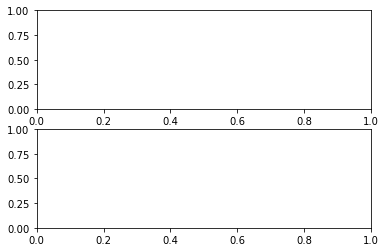

In [133]:
plt.subplots(2,1)[1].ravel()

In [140]:
def corr_heatmap(df):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix))
    sns.heatmap(corr_matrix, annot=True, mask=mask)
def outlier_viz(df, cols:list=None):
    if not cols:
        cols = list(df.select_dtypes('number').columns)
    print(df[cols].describe())

    # create a square of subplots
    if np.sqrt(len(cols)) % 1 == 0:
        square_size = int(np.sqrt(len(cols)))
    else:
        square_size = int(np.sqrt(len(cols)) + 1)
    assert square_size**2 >= len(cols), 'outlier_viz: wrong square size logic'
    
    # plot boxplot for each num feat
    fig, ax = plt.subplots(square_size, square_size, figsize=(square_size*5,square_size*5))
    if square_size == 1:
        sns.boxplot(data=df, x=cols[0], ax=ax)
        plt.suptitle('Outliers visualization')
        plt.show()
    else:
        ax = ax.flatten()
        current_plot = 0
        for i in range(len(cols)):
            sns.boxplot(data=df, x=cols[i], ax=ax[i])
        plt.suptitle('Outliers visualization')
        plt.show()


def drop_zero_records(df, cols:list=None):
    # drop records with 0 in the columns specified 
    if not cols:
        cols = df.select_dtypes('number').columns
    temp_df = df.copy()
    dtypes = dict(df.dtypes)
    for col in cols:
        temp_df.loc[temp_df[col]==0, [col]] = np.nan
        temp_df.dropna(axis=0, subset=[col], inplace=True)
    return temp_df.astype(dtypes) # int cols will get converted to float when replacing nulls
def drop_statistical_outliers(df, cols:list=None):
    # drop records with outlying values in the columns specified
    # outliers are further than 3 SDs from the mean
    if not cols:
        cols = df.select_dtypes('number').columns
    temp_df = df.copy()
    col_stats = {col:(temp_df[col].mean(), temp_df[col].std()) for col in cols}
    for col in cols:
        col_lower = col_stats[col][0] - 3*col_stats[col][1] 
        col_upper = col_stats[col][0] + 3*col_stats[col][1] 
        temp_df = temp_df[(temp_df[col] < col_upper) & (temp_df[col] > col_lower)]
    return temp_df
def drop_minmax(df, col, min_to_keep, max_to_keep):
    # drop values above max_to_keep or below min_to_keep
    return df[(df[col] <= max_to_keep) & (df[col] >= min_to_keep)]

    
def haversine_distance(df, lat1, lat2, lon1, lon2):
    '''
    Simple distance calculator, assume angle is so small since we are only in new york city
    Returns distance in km

    lat1, lat2, lon1, lon2 are col names in df
    '''
    # make a copy
    temp_df = df.copy()
    # The math module contains a function named radians which converts from degrees to radians.
    lat1_rad = np.vectorize(np.math.radians)(df[lat1])
    lat2_rad = np.vectorize(np.math.radians)(df[lat2])
    lon1_rad = np.vectorize(np.math.radians)(df[lon1])
    lon2_rad = np.vectorize(np.math.radians)(df[lon2])

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.vectorize(np.math.sin)(dlat / 2)**2 + \
        np.vectorize(np.math.cos)(lat1_rad) * np.vectorize(np.math.cos)(lat2_rad) * np.vectorize(np.math.sin)(dlon / 2)**2
 
    c = 2 * np.vectorize(np.math.asin)(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    temp_df['trip_distance'] = c*r 
    return temp_df  

In [116]:
drop_zero_records(pd.DataFrame({'col1': [1, 2, 0], 'col2': [0, 3, 4]}))

,col1,col2
1,2,3


In [117]:
drop_statistical_outliers(pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]}))

,col1,col2
0,1,3
1,2,4


In [118]:
drop_minmax(pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]}), 'col1', 1, 1.5)

,col1,col2
0,1,3


# Clean data
- convert to correct datatypes
- check for duplicates
- replacing nulls and filtering out outliers
- feature selection by variance and correlation

In [119]:
assert not df.duplicated().any(), 'Duplicate records found'

In [120]:
df.isna().any()

id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

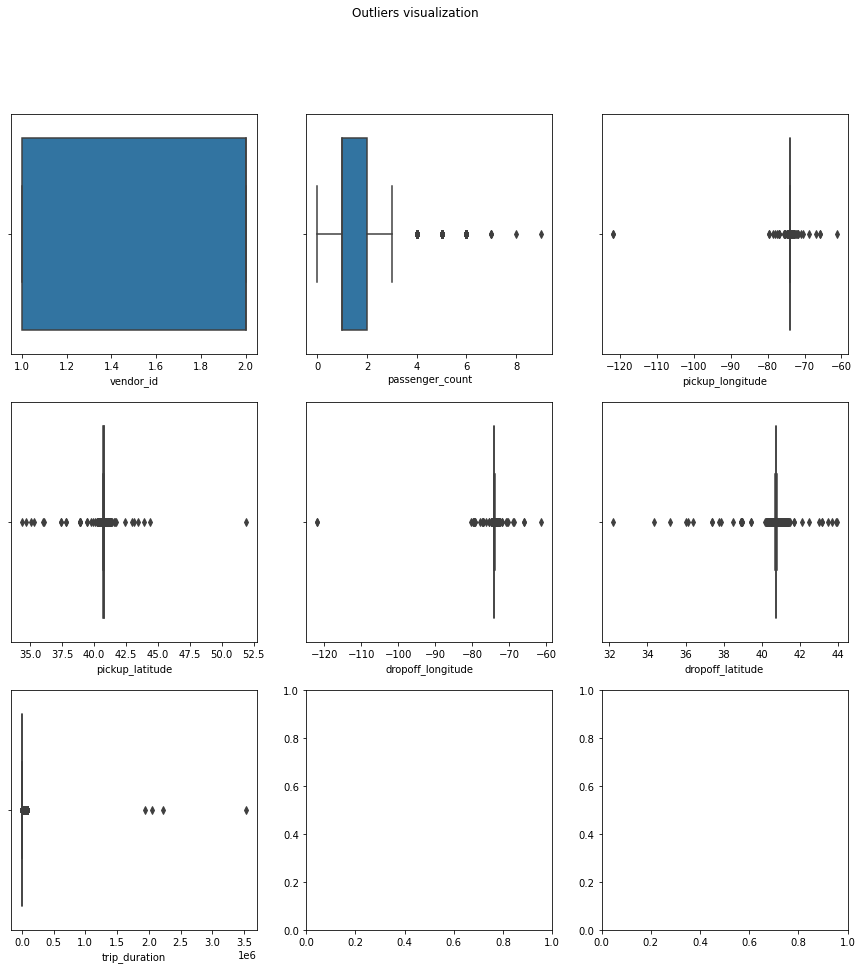

In [142]:
outlier_viz(df)

In [143]:
# passenger_count --> 0 passengers
# longtitude and latitude should be somewhat within NYC's vicinity --> longtitude have min max like frim -120,-60 very weird
# trip duration (seconds) --> max of 3.5 million need to remove outliers

# remove zero passenger
df = drop_zero_records(df, ['passenger_count'])
# remove statistical outliers
df = drop_statistical_outliers(df)
# remove outlying by min max
NYC_MIN_LON, NYC_MAX_LON = -74.4, -73.4 # approx from google map
NYC_MIN_LAT, NYC_MAX_LAT = 40, 41.6
df = drop_minmax(df, 'pickup_latitude', NYC_MIN_LAT, NYC_MAX_LAT)
df = drop_minmax(df, 'pickup_longitude', NYC_MIN_LON, NYC_MAX_LON)
df = drop_minmax(df, 'dropoff_latitude', NYC_MIN_LAT, NYC_MAX_LAT)
df = drop_minmax(df, 'dropoff_longitude', NYC_MIN_LON, NYC_MAX_LON)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.361116e+06     1.361116e+06      1.361116e+06     1.361116e+06   
mean   1.517561e+00     1.513992e+00     -7.397779e+01     4.075328e+01   
std    4.996917e-01     1.057215e+00      2.561877e-02     2.301852e-02   
min    1.000000e+00     1.000000e+00     -7.418407e+01     4.065229e+01   
25%    1.000000e+00     1.000000e+00     -7.399213e+01     4.073883e+01   
50%    2.000000e+00     1.000000e+00     -7.398209e+01     4.075491e+01   
75%    2.000000e+00     2.000000e+00     -7.396871e+01     4.076866e+01   
max    2.000000e+00     5.000000e+00     -7.376234e+01     4.084953e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.361116e+06      1.361116e+06   1.361116e+06  
mean       -7.397505e+01      4.075261e+01   7.878104e+02  
std         3.100411e-02      2.876118e-02   5.764901e+02  
min        -7.418524e+01      4.064413e+01   1.000000e+00  
25%        -7.399142e+01

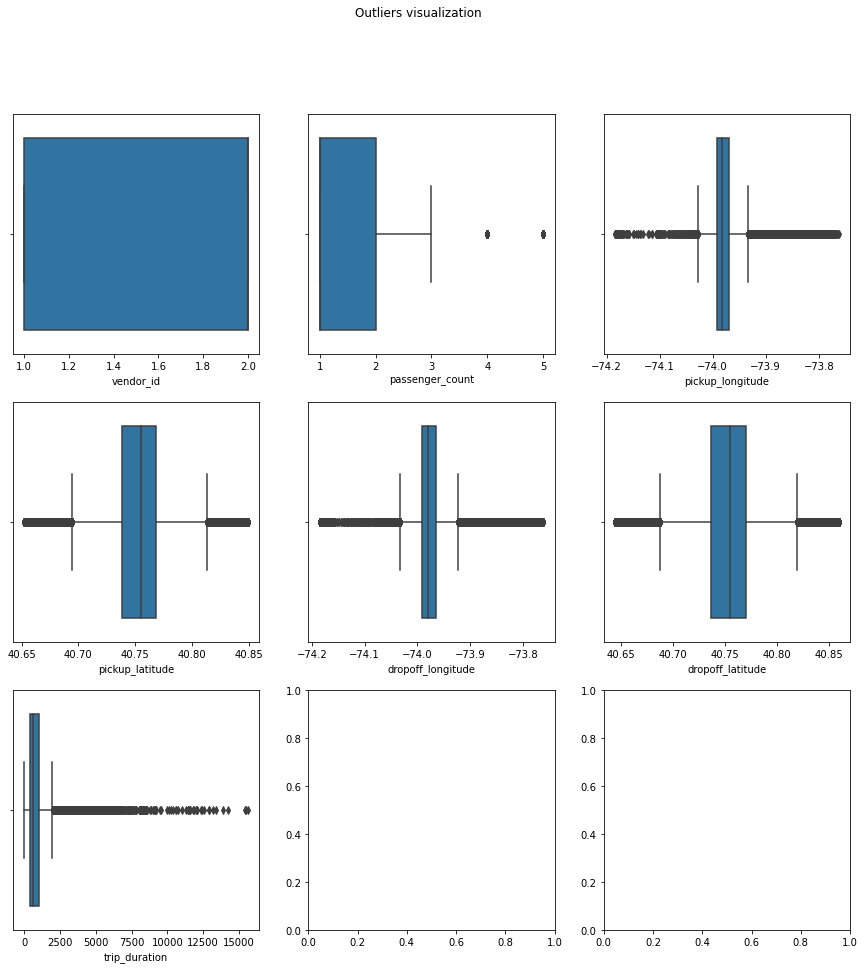

In [144]:
outlier_viz(df)

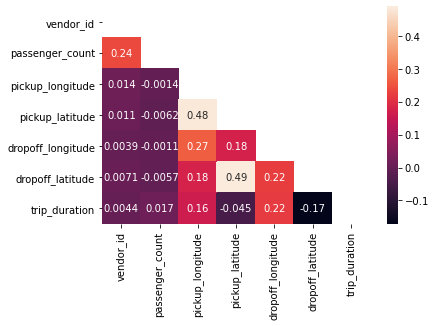

In [145]:
corr_heatmap(df)

# understandable that longtitudes and latitudes have some kind of correlation since they are in the same region

# EDA to get overall insights

In [146]:
print(f'Total trips in dataset = {len(df)} trips')

Total trips in dataset = 1361116 trips


In [147]:
print('Pickup time range:', df['pickup_datetime'].min(), '-', df['pickup_datetime'].max())
print('Dropoff time range:', df['dropoff_datetime'].min(), '-', df['dropoff_datetime'].max())

Pickup time range: 2016-01-01 00:00:17 - 2016-06-30 23:59:39
Dropoff time range: 2016-01-01 00:03:31 - 2016-07-01 00:46:37


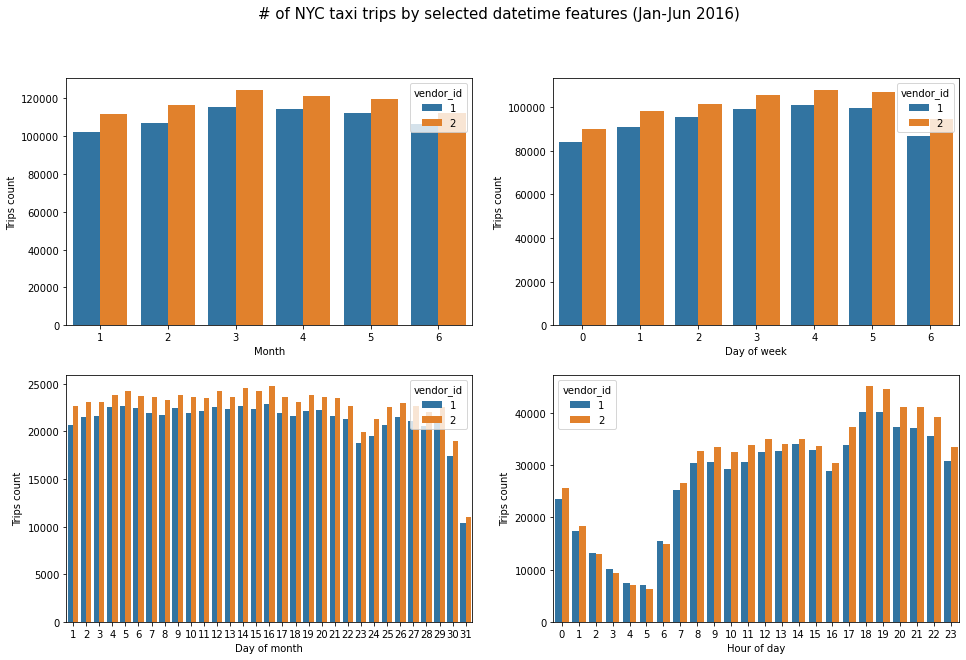

In [148]:
plt.figure(figsize=(16,10))
plt.suptitle('# of NYC taxi trips by selected datetime features (Jan-Jun 2016)', size=15)

plt.subplot(221)
sns.countplot(data=df, x= df['pickup_datetime'].dt.month, hue='vendor_id')
plt.xlabel('Month')
plt.ylabel('Trips count')

plt.subplot(222)
sns.countplot(data=df, x= df['pickup_datetime'].dt.day_of_week, hue='vendor_id')
plt.xlabel('Day of week')
plt.ylabel('Trips count')

plt.subplot(223)
sns.countplot(data=df, x= df['pickup_datetime'].dt.day, hue='vendor_id')
plt.xlabel('Day of month')
plt.ylabel('Trips count')

plt.subplot(224)
sns.countplot(data=df, x= df['pickup_datetime'].dt.hour, hue='vendor_id')
plt.xlabel('Hour of day')
plt.ylabel('Trips count')

plt.show()

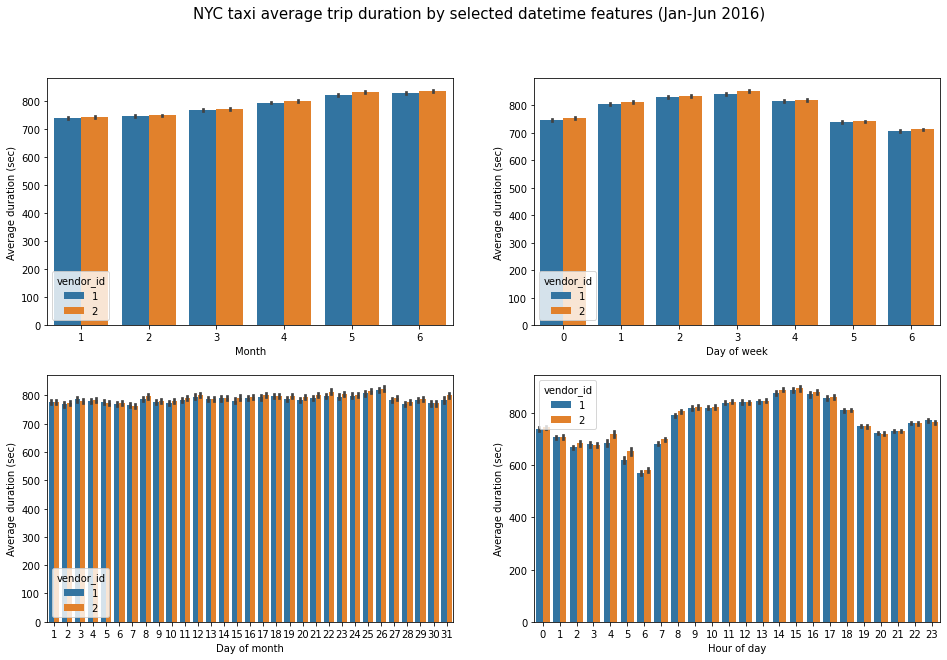

In [149]:
plt.figure(figsize=(16,10))
plt.suptitle('NYC taxi average trip duration by selected datetime features (Jan-Jun 2016)', size=15)

plt.subplot(221)
sns.barplot(data=df, x= df['pickup_datetime'].dt.month, y='trip_duration', hue='vendor_id')
plt.xlabel('Month')
plt.ylabel('Average duration (sec)')

plt.subplot(222)
sns.barplot(data=df, x= df['pickup_datetime'].dt.day_of_week, y='trip_duration', hue='vendor_id')
plt.xlabel('Day of week')
plt.ylabel('Average duration (sec)')

plt.subplot(223)
sns.barplot(data=df, x= df['pickup_datetime'].dt.day, y='trip_duration', hue='vendor_id')
plt.xlabel('Day of month')
plt.ylabel('Average duration (sec)')

plt.subplot(224)
sns.barplot(data=df, x= df['pickup_datetime'].dt.hour, y='trip_duration', hue='vendor_id')
plt.xlabel('Hour of day')
plt.ylabel('Average duration (sec)')

plt.show()

<AxesSubplot:xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

C:\Users\tawiwut.charuwat\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


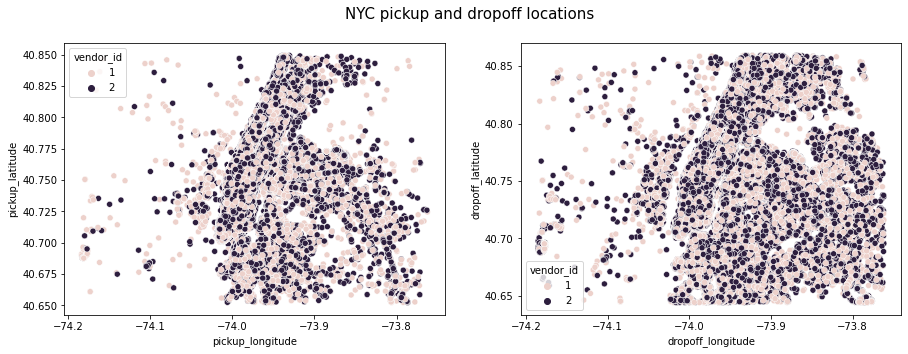

In [20]:
# ~3m to run

# plt.figure(figsize=(15,5))
# plt.suptitle('NYC pickup and dropoff locations', size=15)

# plt.subplot(121)
# sns.scatterplot(data=df, y='pickup_latitude', x='pickup_longitude', hue='vendor_id')

# plt.subplot(122)
# sns.scatterplot(data=df, y='dropoff_latitude', x='dropoff_longitude', hue='vendor_id')

# Feature Engineering
- inspect each feature
- create new features accordingly

## Target variable

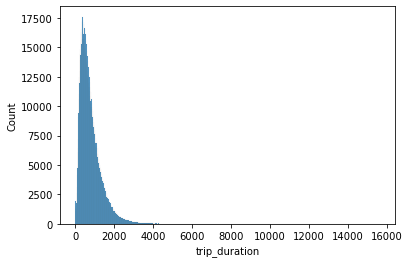

In [72]:
sns.histplot(data=df, x='trip_duration')
plt.show()

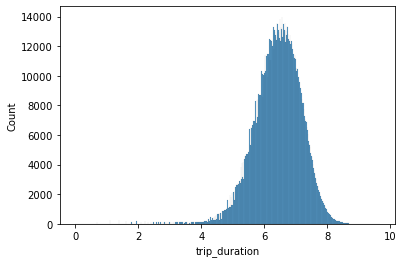

In [73]:
sns.histplot(data=df, x=np.log(df['trip_duration']))
plt.show()

In [74]:
# consider converting target to be kind of normally distributed instead of skewed
df['log_trip_duration'] = np.log(df['trip_duration'])

## Categorical features

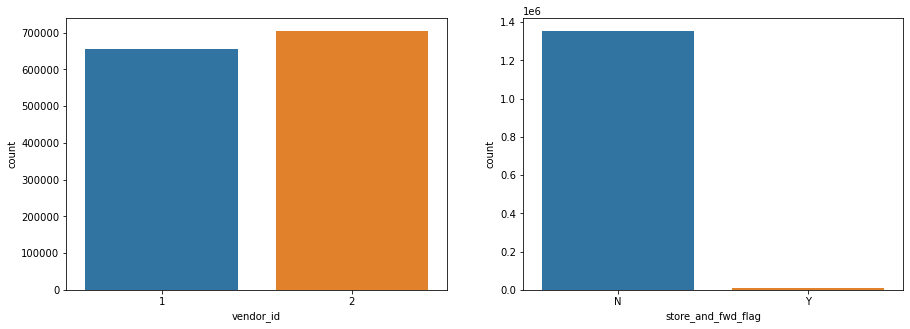

In [80]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.countplot(data=df, x='vendor_id')
plt.subplot(122)
sns.countplot(data=df, x='store_and_fwd_flag')

plt.show()

# both vendors have similar amount of trips
# store_and_fwd_flag feature do not have any value in helping to predict the outcomes

## Datetime features


In [150]:
df['pickup_datetime_month'] = df['pickup_datetime'].dt.month
df['pickup_datetime_date'] = df['pickup_datetime'].dt.day
df['pickup_datetime_day_of_week'] = df['pickup_datetime'].dt.day_of_week
df['pickup_datetime_hour'] = df['pickup_datetime'].dt.hour

df['dropoff_datetime_month'] = df['dropoff_datetime'].dt.month
df['dropoff_datetime_date'] = df['dropoff_datetime'].dt.day
df['dropoff_datetime_day_of_week'] = df['dropoff_datetime'].dt.day_of_week
df['dropoff_datetime_hour'] = df['dropoff_datetime'].dt.hour

## Numeric features


In [151]:
# create trip distance feature
df = haversine_distance(df, 'pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude')

       trip_distance
count   1.361116e+06
mean    2.984235e+00
std     2.897575e+00
min     0.000000e+00
25%     1.212563e+00
50%     2.029004e+00
75%     3.611901e+00
max     3.351988e+01


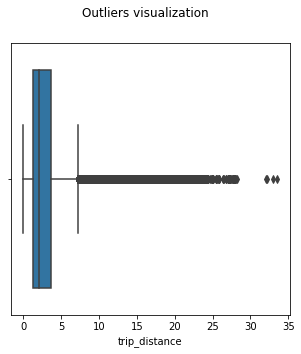

In [152]:
outlier_viz(df, ['trip_distance'])

# need to remove zero distance

In [153]:
df = drop_zero_records(df, ['trip_distance'])

       trip_distance
count   1.356132e+06
mean    2.995202e+00
std     2.897231e+00
min     4.241750e-04
25%     1.219977e+00
50%     2.036486e+00
75%     3.621622e+00
max     3.351988e+01


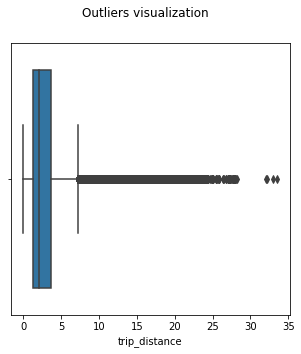

In [154]:
outlier_viz(df, ['trip_distance'])

# need to remove zero distance

# Preprocessing
- select features to feed into model (create a pipeline so we tweak with feature selection)
- preprocessing pipeline from df -> X,y
    - scaling
    - make sure that they comply to stats assumptions 
- train --> train & validate split

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Model selection
- define metric
- select models
- cross validate --> select the most promising

# Hyperparameters tuning

# Train with tuned hyperparams and predict with unseen test data